# Makemore 2

[Video](https://www.youtube.com/watch?v=TCH_1BHY58I)<br>
[Repository](https://github.com/karpathy/makemore)<br>
[Eureka Labs Discord](https://discord.com/invite/3zy8kqD9Cp)

## Table of Contents

- [Goal](#goal)
- [Deep Dive: Bengio et al. 2003](#deep-dive-bengio-et-al-2003)
- [Building the Dataset](#building-the-dataset)
- [Character Embeddings](#character-embeddings)
- [Hidden Layer Construction](#hidden-layer-construction)
- [Output Layer](#output-layer)
- [Condensing the concepts](#condensing-the-concepts)
- [Working with the full dataset](#working-with-the-full-dataset)
    - [Accelerate with Batch-Processing](#accelerate-with-batch-processing)
    - [Improve the Learning Rate](#improve-the-learning-rate)
    - [Split the dataset](#split-the-dataset)
    - [Remove the Embedding Bottleneck](#remove-the-embedding-bottleneck)

## Goal

In the [last lecture](../N002%20-%20Makemore%201/N002%20-%20Makemore.ipynb), we built makemore based on a Bigram model.<br>
Next, we rebuilt it from scratch with a small single-layer neural network.<br>
**Both of these approaches have *serious* limitations.**

For example, the predictions in both cases are based on *one single* previous character for context.<br>
A sole character is the entire context we provide our model for predicting the respective next one.

**And truth be told, in the end, neither of the two models we've built really produce good-looking, convincing names.**

So, if we could use *more than one* character as context for predicting the next character:<br>
**a)** We would be able to model more informed distributions, leading to better predictions<br>
**b)** We would have our two current approaches become *really expensive* really quickly

We already noticed that the neural network (NN) approach is noticeably more flexible and more scalable than the non-learning Bigram model.<br>
**We can improve the neural network approach further by extending the single-layer NN to become a deeper Multi-Layer Perceptron Model (MLP)**.<br>
For the extension, we will follow the general approach from this very well-written paper: [\[Bengio et al. 2003\]](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available

## Deep Dive: Bengio et al. 2003

[\[Bengio et al. 2003\]](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) develops a *word-level* language model with a vocabulary size of $17,000$ words.<br>
Note that the models we built before were *character-level*.<br>
**We intend to keep our work at the character-level, but model our MLP in the same spirit as the one in the paper.**

The paper assigns a $30$-dimensional feature vector to every input word from the vocabulary.<br>
This is achieved by mapping the word to a point in a continuous, real-valued vector space.<br>
The feature values do **not** necessarily explicitly represent individual letters or positions in the word.<br>
Instead, they rather encode semantic and syntactic relationships between words.

In other words, in the paper's *word-level* model, each input is a whole word from a vocabulary of $17,000$ entries and **not** a sequence of letters.<br>
Each word is mapped to a $30$-dimensional vector using a lookup table, where every word index corresponds to one unique vector.

![](./img/bengioetal03.PNG)<br>
*(This image is bottom-up, i.e. the input is at the bottom)*

> In the paper, **multiple words** are read into the model as input, i.e. multiple word vectors.<br>
> An example input thus could be: `"A dog was running in a [...]"`

Staying with the paper, suppose we have $3$ words. We embed them, giving us three $30$-dimensional vectors.<br>
The resulting concatenation of these vectors forms the input for a fully-connected layer, which can be chosen arbitrarily wide.<br>
Note that the layer's width is logically decoupled from the amount of words in the input.<br>
The layer's output is activated using $\tanh$.<br> 

Another layer follows. It is fixed at a width of $17,000$ neurons, and has `softmax` applied to its output.<br>
We encountered `softmax` already in the [last lecture](../N002%20-%20Makemore%201/N002%20-%20Makemore.ipynb). In short `softmax` normalizes the outputs to partial probabilities over the set of the $17,000$ possible words.<br>
In the end, we can sample from this distribution to get the predicted next word's index.<br>
Backprop can then be performed during training based on comparing the predicted distribution with a one-hot encoding of the actual next word in the training data.

The dotted lines in the image can be ignored. That is an idea that we will not consider further here.<br>
So let's start (as with the prior makemore part) by creating the necessary data structures.

**Shifting now from the paper to our needs, we want:**
- A lookup table for *character* embedding vectors (not *word* embeddings, we deviate in this)
- A fully-connected layer, $\tanh$-activated, arbitrary width, to process the set concatenated embedding vectors forming the input
- Another fully-connected layer, $\text{softmax}$-ed, with a fixed width of $27$ characters to form the output distribution over the next character's candidates<br>(you will see where the number $27$ comes from shortly)
- A loss function
- A training loop

## Building the dataset

We will again use the `names.txt` dataset and just like before, follow the objective of generating more names that look like the ones in the dataset.<br>

In [2]:
# Read all 32033 names, split them into a list of strings
words = open('../names.txt', 'r').read().splitlines()
print(f"First eight names in dataset:\t\t{words[:8]}")
print(f"Count of names in dataset:\t\t{len(words)}")
print(f"Count of unique characters in dataset:\t{len(list(set(''.join(words))))}")

First eight names in dataset:		['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Count of names in dataset:		32033
Count of unique characters in dataset:	26


Just like in our [prior lecture](../N002%20-%20Makemore%201/N002%20-%20Makemore.ipynb), we create two mappings 'integer-to-character' (`itos`) and 'character-to-integer' (`stoi`) to work with the $27$ possible characters ($26\ +$ `.`) from our dataset.

In [3]:
# build a vocabulary of characters and map them to integers
chars = sorted(list(set(''.join(words)))) # set(): Throwing out letter duplicates

# Create map from character to integer index
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # Add special character's entry explicitly

# Switch order, create map from integer index to character
itos = {i:s for s,i in stoi.items()}

# Showing the first 10 entries of the two mappings
# (they just mirror each other)
print(f"Integer-to-Character Map: {list(itos.items())[:10]}")
print(f"Character-to-Integer Map: {list(stoi.items())[:10]}")

Integer-to-Character Map: [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e'), (6, 'f'), (7, 'g'), (8, 'h'), (9, 'i'), (10, 'j')]
Character-to-Integer Map: [('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5), ('f', 6), ('g', 7), ('h', 8), ('i', 9), ('j', 10)]


To now prepare our `names.txt` dataset, we define a new parameter `block_size`.<br>
This new parameter states how many characters we will evaluate from a name in order to predict the next character.<br>
We set `block_size` to $3$ for now.

In [4]:
# Building the dataset
block_size = 3 # context length: how many characters are used to predict the next? (this was 1 before)
X, Y = [], []  # features (input, the context) and labels (output, the next character)

# Iterating over the first five names
# Splitting each into characters getting mapped to their indices
# and then forming the input context and the expected output character entry for the training data
for w in words[:5]:
    print(f'\n{w}')
    context = [0] * block_size # context/input initialized as list of block_size many zeros (0 is the index for the special character '.')
    for ch in w + '.':    # iterate over characters of name; name is made to end with our special character
        ix = stoi[ch]     # map character to its index
        X.append(context) # append current context to list of inputs
        Y.append(ix)      # append character's index to list of labels
        # Showing what input and expected output now look like
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        # crop and append, like a sliding window; NEAT!
        # new context starts at index 1 of the old one and is appended with the single new index,
        # coincidentally, this is the label of the input-label pair produced earlier -> sliding window over block_size many characters
        context = context[1:] + [ix] # New context is 

# again, these *do not* carry characters, but their respective indexes
X = torch.tensor(X) # block_size many character indices form the input; shape: (number of training examples, block_size)
Y = torch.tensor(Y) # the index of the next character forms the label; shape: (number of training examples,)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .

olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .

ava
... ---> a
..a ---> v
.av ---> a
ava ---> .

isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .

sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
print(f'Input:  {X.shape}\tdtype: {X.dtype}\tInitial example: {X[0]}') # 32 times the 3 character indices forming one input example
print(f'Output: {Y.shape}\tdtype: {Y.dtype}\tInitial example: {Y[0]}') # 32 times the index of the character after the 3 character indices of the input

Input:  torch.Size([32, 3])	dtype: torch.int64	Initial example: tensor([0, 0, 0])
Output: torch.Size([32])	dtype: torch.int64	Initial example: 5


## Character Embeddings

For our `names.txt` dataset, we can now begin building a neural network inspired by the paper.<br>
We begin with a lookup table `C` that maps each of the $27$ possible character indices<br>
($26$ characters plus the special `.` character) to a respective $2$-dimensional vector each.<br>
The embedding size of $2$ is chosen so we can nicely visualize the learned representations later.

In [6]:
# This will be our lookup table, randomly initialized
C = torch.randn((27, 2)) # each of the 27 character indices gets its own unique 2-dimensional numeric embedding
print(C)

tensor([[-0.4419,  0.1553],
        [-1.6764, -0.3994],
        [ 0.2392,  0.5514],
        [ 0.8007, -0.2385],
        [-0.5862,  1.6433],
        [-0.5207,  0.1235],
        [-0.8141,  0.1193],
        [-1.8369,  2.0794],
        [-0.9639, -1.1367],
        [-0.3800,  1.1889],
        [-0.6910,  0.1486],
        [ 1.2373,  0.9832],
        [-0.3871, -0.4789],
        [-0.9008,  0.9777],
        [-0.9691, -0.2301],
        [ 1.1531,  0.6399],
        [-0.7923, -0.8893],
        [-1.2573, -0.6138],
        [-0.2224, -0.8774],
        [ 0.4720, -1.4401],
        [ 0.6611,  2.1106],
        [ 1.6101,  0.4079],
        [-0.9142, -0.1439],
        [-0.0656,  0.2405],
        [-0.2395,  0.4158],
        [-0.0672,  1.9994],
        [-0.9840,  0.3630]])


Before we embed all of $X$ through $C$, let's play around with this concept of *embedding* with a single numeric value first:

In [7]:
xc = 'e'
i_xc = stoi[xc]
print(f"Embedding of character '{xc}' through its index {i_xc} in C: {C[i_xc]}")

Embedding of character 'e' through its index 5 in C: tensor([-0.5207,  0.1235])


**Great!**

In the [last lecture's](../N002%20-%20Makemore%201/N002%20-%20Makemore.ipynb) iteration on makemore we had used *One-Hot Encoding*.<br>
Curiously, we had only used it for the label representation, which had allowed us to calculate the *Negative Log-Likelihood* loss based upon which we ultimately could backpropagate.

Interestingly, with our current setup, **we can use *One-Hot Encoding* for the input representation as well:**

In [8]:
# Given 27 possible characters, embed the number 5 (provided through stoi['e'])
F.one_hot(torch.tensor(stoi['e']), num_classes=27) # shape is (27,)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

If we now multiply this One-Hot vector with the embedding matrix `C`, the One-Hot vector conveniently acts as a selector.<br>
It plucks out the row in `C` at the index specified through the `stoi` value it encodes.<br>
For `5 = stoi['e']` represented as a One-Hot vector, matrix multiplication with `C` has us obtain the same result as indexing into `C`: `C[stoi['e']]`.<br>
**That is neat.**<br>

Although One-Hot encoding may seem like an unnecessary extra step, it converts each character index into a fixed $27$-dimensional vector.
This ensures the model treats characters as discrete categories rather than scalar numerical values, and it allows us to use matrix multiplication with the embedding matrix.

The insight here is that **while One-Hot encoding the input doesn't improve backpropagation itself, it makes the embedding lookup differentiable** and mathematically more consistent.

This is what we can do with such a One-Hot vector:

In [9]:
print(F.one_hot(torch.tensor(stoi['e']), num_classes=27).float() @ C) # stoi['e'] = 5
print(F.one_hot(torch.tensor(stoi['e']), num_classes=27).float() @ C == C[stoi['e']])

tensor([-0.5207,  0.1235])
tensor([True, True])


Sounds good?<br>
*Well, we won't use it.*

**Why?** While this is an established technique, a direct call like `C[5]` is sufficient for our needs.<br>
Still, the effect of One-Hot Encoding is very interesting in this case. And understanding why one might want to use it here will come in handy later.<br>
Applying One-Hot encoding makes an operation like `C[5]` differentiable.<br>
<br>
**But then how do we now get all $32\times 3$ integer index values from our training set `X` embedded?**<br>
Where does the $32\times 3$ shape of `X` come from?<br>
Well, we have $32$ inputs from the originally $5$ words we comprised our small dataset of.<br>
Each of these input contexts consists of $3$ character indices. The $32$ thus is directly related to our arbitrary choice of dataset size.<br>
Fortunately, Python is *quite flexible* when it comes to slicing.<br>
But to properly leverage the slicing flexibility, we have to *really* understand it.

For example, given the embedding vector `a` or the embedding matrix `b`, you can request multiple embeddings at once from either like so:

In [ ]:
# a is (27,) tensor with values from 0 to -26 (negative to show we really obtain the values from a below)
a = -torch.arange(27)
print("Results for the single dimension tensor a:")
print(a[[3,4,5]])                     # tensor([-3, -4, -5])
print(a[[torch.tensor([3,4,5])]])     # same
print(a[[torch.tensor([3,4,4,4,5])]]) # tensor([[-3, -4, -4, -4, -5]]), we can even repeat indices as we like

# b is just a but copied along the second dimension (two identical columns looking like a)
b = a.unsqueeze(1).expand(-1, 2)
print("\nResults for the two-dimensional tensor b:")
print(b[[3,4,5]])                     # tensor([[-3, -3], [-4, -4], [-5, -5]]), we pick out multiple vectors from indices 3, 4, and 5 now
print(b[[torch.tensor([3,4,5])]])     # same again
print(b[[torch.tensor([3,4,4,4,5])]]) # tensor([[-3, -3], [-4, -4], [-4, -4], [-4, -4], [-5, -5]])

Results for the single dimension tensor a:
tensor([-3, -4, -5])
tensor([-3, -4, -5])
tensor([-3, -4, -4, -4, -5])

Results for the two-dimensional tensor b:
tensor([[-3, -3],
        [-4, -4],
        [-5, -5]])
tensor([[-3, -3],
        [-4, -4],
        [-5, -5]])
tensor([[-3, -3],
        [-4, -4],
        [-4, -4],
        [-4, -4],
        [-5, -5]])


**We can use this slicing technique to our advantage.**

As `X` carries the indices of the characters, we can use it to index into `C` directly:

In [12]:
# We can write this:
print(X[13, 2])   # Plugging out an example character, here 'a' from ..a ---> v (14th input, 3rd character)

# As the above holds, we can also write this:
print(C[X][13,2]) # This construct actually returns the 2-dim. embedding vector for 'a'

# Given the slicing technique from above, which works with entire tensors for indexing, we can therefore write this:
emb = C[X] # For each index in each input conext, we get the corresponding embedding vector from C

print(C[X].shape) # 32 times 3 times 2 -> 32 inputs, 3 characters each, 2 dimensional embedding vector each

tensor(1)
tensor([-1.6764, -0.3994])
torch.Size([32, 3, 2])


## Hidden Layer Construction

Given we now have a `C`, it's time to implement the hidden layer.<br>
This is the layer that processes the concatenated embedding vectors of the input characters and produces an output that will be fed into the output layer for prediction.<br>
As we said before, we can make this hidden layer *as wide as we want*.

**But one thing should be kept in mind:**<br>
We receive three character embedding vectors from embedding our training input through `C`.<br>
Each embedding vector contains two numerical values.<br>
Therefore, we need to consider a total of $6$ inputs per character context,
provided in the form of a matrix of shape `32, 3, 2` we'll call `emb`<br>
(`32` contexts in `X`, `3` characters per context, `2` values per character embedding).<br>

Below, we begin to construct a hidden layer that, per context, takes in the `3,2` shaped inputs and produces a respective output of shape `3, 100`.

In [13]:
W1 = torch.randn((6, 100)) # 6 -> 3 vectors á 2 values, 100 neurons
b1 = torch.randn(100)      # for each of the 100 neurons, add a bias

Intuitively, all that is left to do is calculating $emb\ @\ W1 + b1$, **which doesn't work.**

**Problem:**<br>
The multiplication of $emb$ (`32, 3, 2`) with $W1 + b1$ (`6, 100`) is not possible.<br>
We have to find a way to reasonably mend `emb` to be of shape `32, 6` for the multiplication.

**Solution:**<br>
We can concatenate the `32` individual `3, 2` vectors inside `emb` horizontally.<br>
This has us obtain `32` vectors again, one per input, but now with with $3 \times 2 = 6$ dimensions each, two for each embedded character, in order of their appearance in the input.<br>
There are many ways to achieve this reshaped `emb`.<br>
PyTorch is almost *too versatile* for this, actually.

Let's try with the function `cat()`, but before, let's understand the slicing we will use for it:

In [17]:
# 32 vectors, one for each input tuple (3 characters, 2 values each)
emb_first_chars = emb[:, 0, :] # Embedding vectors for the first character of each of the 32 input tuples
print(emb_first_chars.shape)   # 32 times 2 -> 32 inputs, 2 values each

torch.Size([32, 2])


In [18]:
# Concatenating all three input character embedding vectors into one 6-dimensional vector
# 1 means: Concatenate along the first dimension (rows) -> 32 times 6
emb_concat = torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1)
print(emb_concat.shape)

torch.Size([32, 6])


This is *exactly* what we needed.<br>
We now have $32$ vectors of width $6$ instead of $32 \times 3$ vectors of width $2$ each.

**But we have another problem:**<br>
If we were to change the `block_size` from `3` to `something else`, we would have to adapt this explicit concatenation code.

**Solution:**<br>
We should ditch using `cat()` in this particular way.<br>
Instead, we can use `unbind()` to split the tensor into a list of tensors, which we can then concatenate again with `cat()`.<br>
This way we can generalize the code to any `block_size`. It is not hard-coded inside the concatenation call anymore.

We now build, in a generalized way, what we had above with `cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1)`:

In [30]:
# We separate the 32x3x2 into a tuple of 3 individual 32x2 tensors using unbind()
# 1 -> dimension 1 is the axis along a tuple of (3 for 32x3x2) tensors gets created, each 32x2 ('the other two' dimensions)
emb_unbound = torch.unbind(emb, 1)

print(f"The .unbind() produces an object of class: {type(emb_unbound)}") # We've got a tuple now
print(f"We find the object to contain {len(emb_unbound)} elements")  # The tuple contains three tensors
print(f"Each element is of shape {emb_unbound[0].shape}\n")          # This is equivalient to the above used list [emb[:,0,:], emb[:,1,:], emb[:,2,:]]

# We can now go and concatenate the three 32x2 tensors in the tuple along dimension 1 again, 
# to get back to the 32x6 shape we need for the multiplication with W1 and b1
emb_generalized = torch.cat(emb_unbound, 1) # 32x6, just like before, but without ever having fiddled with the specific block size of 3 in the code
print(f"Resulting shape of the generalized concat approach: {emb_generalized.shape}")

The .unbind() produces an object of class: <class 'tuple'>
We find the object to contain 3 elements
Each element is of shape torch.Size([32, 2])

Resulting shape of the generalized concat approach: torch.Size([32, 6])


---

**Why did we just do all of that?**

We took the letters of our names.<br>
For each letter, we recorded the $3$ preceding characters as the context.<br>
If there were none, this context was filled and with our special character `.`.<br>
The respective follow-up letter is the output we expect to follow the input of the $3$ preceding characters.<br>
The triplets are the inputs. But we embed them first into numeric vectors.

For each input triplet, we go through the characters and assign the respective alphabetical character index.<br>
For each character index, we then look up the corresponding $2$-dimensional embedding vector in the lookup-table `C`.<br>
**Every letter of the input triplet now gets represented by a $2$-dimensional vector.**

The next layer expects $6$ inputs and feeds those to $100$ neurons.<br>
The $6$ results from the fact that we, per example, have $3$ characters represented by $2$ elements each.

And at this point, the problem arose which we just discussed above:<br>
As our training dataset `X` happens to contain $32$ entries.<br>
We therefore have $32$ triplets total and per triplet, we just build $3$ vectors with $2$ elements each.<br>
Pushing this $32 \times 3 \times 2$ through the $6 \times 100$ layer is not possible.<br>
To resolve this shape mismatch, we used `torch.cat()` row-wise on every $3$ vectors á $2$ values, concatenating them in order into one $6$-value vector.<br>
We did this for all $32$ triplets, producing the now processable matrix shape $32 \times 6$ to multiply with the $6, 100$ layer weights. **Problem solved.**

**We didn't quite resolve it at first, though**, because we initially concatenated by hard-coding the `block_size` of $3$ into the code.<br>
We needed to generalize for any `block_size`, which is why we used `torch.unbind()` on top of `torch.cat()`.

---

We already experienced PyTorch's flexibility with slicing and indexing of tensors.<br>
Actually, let's take another closer look at how tensors are mendable in PyTorch:

In [56]:
a = torch.arange(18)

# All of these tensors contain exactly the same data, but they are different shapes:
print(f"Arange shape: {a.shape}:\n{a}\n")                                # 1-dimensional tensor with 18 elements
print(f"Unsqueeze 0 shape: {a.unsqueeze(0).shape}:\n{a.unsqueeze(0)}\n") # 2-dimensional tensor, 1 row, 18 columns
print(f"Unsqueeze 1 shape: {a.unsqueeze(1).shape}:\n{a.unsqueeze(1)}\n") # 2-dimensional tensor, 18 rows, 1 column

# We can also re-interpret this 18-element tensor from (18) to be (3,3,2) (as 3x3x2 = 18)
# This is very efficient, no actual re-arranging of data, just the view on it changes
a = a.view(3, 3, 2)
print(f"View (3,3,2) shape: {a.shape}\n")

# Can we transfer this .view approach to our 32x3x2 tensor problem?
# Long story short: Yes, we can! All of the above is equivalent to just re-arranging how we look at the data
equiv = True
equiv if torch.all(torch.eq(emb.view(32, 6), torch.cat(torch.unbind(emb, 1), 1))) else not equiv
print(f"Does the .view() approach give the same result as the generalized unbind and concat approach?\n-> {equiv}")

Arange shape: torch.Size([18]):
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

Unsqueeze 0 shape: torch.Size([1, 18]):
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]])

Unsqueeze 1 shape: torch.Size([18, 1]):
tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17]])

View (3,3,2) shape: torch.Size([3, 3, 2])

Does the .view() approach give the same result as the generalized unbind and concat approach?
-> True


The `view()` function is *very* useful as it allows us to reshape a tensor in any way we want, as long as the total number of elements stays the same.<br>
More on this in [ezyang's excellent blog post](http://blog.ezyang.com/2019/05/pytorch-internals/).

**Ok, now for real.** We will adjust the correct matrix `emb` using `view()`.<br>
We do this right within the calculation of the hidden layer:

In [58]:
# h is the activated ouput of the hidden layer
# h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1) # emb.shape[0] is 32, but we can and should make this flexible

# Alternative to the above suggested:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
# PyTorch reads the -1 and infers, because 6 is already used up from (2x3): 32 times 6 or inputs times 6 generally

# Let's see what h and its contents look like
print(h.shape)  # 32 times 100 activations of the hidden layer
print(h[0][:5]) # first five activations

torch.Size([32, 100])
tensor([ 0.6261,  0.6219,  0.9677, -0.3676, -0.3688])


We kind of glossed over the intricacy that is multiplying and adding tensors *correctly*.<br>
It is an issue of broadcasting, *again*.

For the above, we know:

In [60]:
print((emb.view(-1,6) @ W1).shape) # (32, 100), the logits before adding the bias and activating
print(b1.shape) # (100), the bias we want to add to the logits before activation

torch.Size([32, 100])
torch.Size([100])


**Broadcasting affects the application of the bias tensor like so:**

1) **Right-aligning dimensions** (of all tensors)

- $[32, 100] \rightarrow [32, 100]$ remains the output shape of the matrix multiplication of `emb` with `W1`
- $[100]\ \ \ \ \ \ \rightarrow [\ \ \ \ \ \ 100]$ symbolizes the need for right-aligning the bias tensor dimensions

2) **Adding missing leading dimensions to the lower-rank right-aligned tensor**

- $[32, 100] \rightarrow [32, 100]$ remains the same, this is the higher-rank tensor
- $[\ \ \ \ \ \ 100] \rightarrow [1, 100]$ we add a leading dimension to the bias tensor to match the higher rank

3) **Expanding the dimensions of size $1$ to match in shape**

- $[32, 100] \rightarrow [32, 100]$ again remains unchanged
- $[1, 100]\ \ \rightarrow [32, 100]$ we broadcast (virtually expand) the $100$ bias values $32$ times, one copy for each of the now $32$ dimensions

Ultimately, when adding the bias term like so `emb.view(-1, 6) @ W1 + b1`,<br>
all of the $32$ sets of $100$ neurons get incremented each by the same set of $100$ biases now.<br>
That's good, because we want to actually increment each input by the always same bias values.


## Output Layer

The logic for our output layer closely resembles the setup of our hidden layer.<br>
One difference, apart from the different dimensions of the tensors, is the **activation function.**<br>
We use `softmax` instead of `tanh` to obtain a normalized distribution over the $17,000$ possible words.<br>
We will go on to interpret this as a probability distribution over the next character's candidates.

In [61]:
# Initialize weights and biases for the output layer randomly
W2 = torch.randn((100, 27)) # 100 inputs, 27 output neurons, 27 is fixed due to the 27 possible characters in the dataset
b2 = torch.randn(27)        # 27 biases

# Raw neuron outputs
logits = h @ W2 + b2
print('Logits:', logits.shape) # (32, 27) -> 32 outputs, 27 dimensions each

# Softmax transforms outputs into a normalized distribution over the 27 possible characters
pseudo_counts = logits.exp() # Refer to N002 for why I call this pseudo_counts and not counts
prob = pseudo_counts / pseudo_counts.sum(1, keepdims=True)
print('Probabilities:', prob.shape) # (32, 27) -> 32 distributions across 27 next character candidates each

Logits: torch.Size([32, 27])
Probabilities: torch.Size([32, 27])


We now have to compare the output from each of the $32$ distributions from the last layer to the respective $32$ labels found in `Y`.<br>
Related to what we did in the [last lecture](../N002%20-%20Makemore%201/N002%20-%20Makemore.ipynb), first, we want to index into the rows of `prob` with the indices found in `Y`:

In [64]:
Y[0] # For reference, this is the first expected output, the index of the first character following the first input triplet

tensor(5)

This code now very beautifully indexes into the $32$ rows of `prob` with the respective indices from `Y` indexing into the columns.<br>
This provides us the probability assigned to the respective true next character, and it does so *at once* for each of the $32$ examples:

In [67]:
# For each of the 32 input triplets:
# Give the probability assigned to the correct character, which is accessible at the index stored in Y
print(prob[torch.arange(32), Y])
print(prob[torch.arange(32), Y].shape) # 32 probabilities, one per each ground truth next character

tensor([4.3258e-05, 3.6110e-07, 2.5562e-04, 2.5120e-03, 1.0221e-09, 2.8201e-02,
        3.0011e-05, 7.5807e-08, 5.1766e-08, 2.0301e-09, 8.7070e-08, 3.0132e-10,
        1.3561e-03, 2.4020e-07, 2.3867e-06, 8.3649e-08, 6.5333e-13, 1.0513e-08,
        3.4169e-09, 1.5962e-11, 4.3609e-06, 2.6809e-02, 5.9863e-10, 7.8808e-09,
        7.1531e-06, 4.8931e-06, 1.3681e-05, 1.1004e-16, 1.0353e-13, 9.9545e-10,
        4.0749e-07, 3.3118e-08])
torch.Size([32])


Remember, these above values are the probabilities assigned to the indices for which we know from `Y` that they should have been $1.0$.<br>
With this knowledge, we now build the cost function to compare the predictions to the labels.

In [69]:
# We want the average log proability over all 32 inputs to be our loss
loss = -prob[torch.arange(32), Y].log().mean()
print(loss.item()) # This is to be minimized

16.17192840576172


**Wait, no step for one-hot encoding of the labels? Why?**<br>
The above code exactly implements the *negative log-likelihood* loss, which we had also implemented in the [last lecture](../N002%20-%20Makemore%201/N002%20-%20Makemore.ipynb) but with one-hot encoding of the labels.<br>
The key is that where we last time had been very explicit about the one-hot encoding of the labels, we don't need to be here.<br>
We are not losing any information by skipping the explicit one-hot vector, as what we calculate here is, per each of the $32$ examples, mathematically identical to:

$$\text{loss} = -\frac{1}{32}\sum_{i = 0}^{31}\sum_{c = 0}^{26} \text{y}_{i,c} \log \text{prob}_{i,c}$$

When we calculate the `-prob[torch.arange(32), Y].log().mean()` we effectively obtain for each example $i$ the only term from $-\sum_{c = 0}^{26} \text{y}_{i,c} \log \text{prob}_{i,c}$ that is non-zero.<br>
This is the exact term for which $y_{i,c}$ would be $1.0$ in a one-hot vector.<br>
And we retrieve that for each $i$, `.mean()` over the amount of examples and negate them.

This configuration of the negative log-likelihood loss can now also be refered to as the **cross-entropy loss** between the true label distribution $y_{i,c}$ and the predicted distribution $p_{i,c}$. **Cross-entropy** is defined as $-\sum_c y_{i,c} \log p_{i,c}$, and for a one-hot target, this sum reduces to $-\log p_{i, Y_i}$, which is exactly what we compute via indexing.

> The negative log-likelihood loss is a special case of the cross-entropy loss where the target distribution is a one-hot vector.<br>In our case, since we are directly indexing into the predicted probabilities with the true class indices, we are effectively computing the negative log-likelihood without explicitly forming the one-hot vectors. The cross-entropy loss more generally allows us to compare any target distribution (not just one-hot) to the predicted distribution.

## Condensing the concepts

Now we can go on to assemble a concise version of the network, integrating the components we've developed step-by-step so far.<br>
Remember, our overall goal is replicating makemore based on the [paper's](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) MLP architecture:

In [76]:
print('X:', X.shape)
print('Y:', Y.shape, '\n')

block_size = 3 # this is the context length (how many characters are used to predict the next one)

# Let's re-initialize the MLP's weights and biases
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          #  27 characters, 2 embedding dimensions each
W1 = torch.randn((block_size * C.shape[1], 100), generator=g) # block_size times embedding dimension as input (3x2=6) to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases to be added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           #  27 biases to be added to the  27 output neurons

parameters = [C, W1, b1, W2, b2] # Group all layers' parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # print total #parameters (nelements = number of elements)

X: torch.Size([32, 3])
Y: torch.Size([32]) 

3481 parameters


In [77]:
# Go over parameters, have them allow gradient accumulation
for p in parameters:
    p.requires_grad = True

In [ ]:
# Run for 1000 training epochs
for _ in range(1000):
    ## Forward-Pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    
    # Replacing the above lines with PyTorch's built-in cross entropy loss function:
    # this function behaves better numerically and avoids pitfalls like infinities by subtracting the maximum value from all logits before exponentiating
    loss = F.cross_entropy(logits, Y)

    ## Backward-Pass
    # Clear gradients before each backward pass, avoiding accumulation across multiple passes
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # Update parameters using gradient descent and a learning rate of 0.1
    for p in parameters:
        p.data += -0.1 * p.grad # Nudge parameter values in negative gradient direction

print(loss.item())

0.2561509907245636


We've implemented our version of *Cross-Entropy* using `softmax` in a pretty literal way so far.<br>
*This is pretty inefficient.* PyTorch can provide significant performance boosts through internal condensing.

Condensing has the following benefits:
1. The forward pass becomes more efficient,
2. Backprop becomes more efficient,
3. The Cross-Entropy is "numerically more well-behaved", i.e. it is calculated more robustly (see the upcoming code's comments on this.)

With the code from above, we train on only $32$ inputs. And we do so for $1000$ epochs.<br>
This has us heavily overfit our $3481$ network parameters to these few examples.

> The *bigger* the parameter count and the smaller the input set, the *higher* the risk of overfitting.<br>Overfitting means we increasingly internalize non-generalizable patterns of the training data, leading to increasingly worse performance on unseen data. Think of it as the model explicitly and only memorizing the training data, not the generalizable value contained therein.

Comparing the `logits` (the actual network outputs) to the labels `Y`, we see that the predictions are visibly mimicking the labels:

In [ ]:
# For each of the 32 inputs, give the index of the highest probability output neuron
print(logits.max(1)) # This is what the network thinks is the respectively most likely next character
print(f'\n{Y}')

torch.return_types.max(
values=tensor([13.3437, 17.7879, 20.5832, 20.6042, 16.7390, 13.3437, 15.9747, 14.1889,
        15.9158, 18.3894, 15.9409, 20.9284, 13.3437, 17.1212, 17.1498, 20.0637,
        13.3437, 16.4564, 15.1328, 17.0537, 18.5905, 15.9655, 10.8739, 10.6874,
        15.5062, 13.3437, 16.2394, 16.9563, 12.7426, 16.2141, 19.0840, 16.0213],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])


In some cases, though, the predictions are not equal to the labels. **Why is that?**<br>
In practice, we will actually *never* reach a $0.00$ loss. 

This is because of triplet-label combinations like these:<br>
`... -> a`<br>
`... -> e`

**Given the same input, different outputs are expected. This necessarily trips up the model.**

## Working with the full dataset

We can go ahead and perpare the full dataset now.<br>
Forget the ominous $32$ inputs, now it's this many:

In [27]:
# Build the dataset
block_size = 3  # context length: how many characters used to predict the next? (1 before)
X, Y = [], []   # features (input) and labels (output)

# Just show the first three words as example
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        
        X.append(context)
        Y.append(ix)
        
        # Showing what input and expected output now look like
        context = context[1:] + [ix] # crop and append, like a rolling window; NEAT!

# These DO NOT carry characters, but their respective index numbers
X = torch.tensor(X)
Y = torch.tensor(Y)

print('Input:', X.shape, X.dtype, X[0])
print('Output:', Y.shape, Y.dtype, Y[0]) 

Input: torch.Size([228146, 3]) torch.int64 tensor([0, 0, 0])
Output: torch.Size([228146]) torch.int64 tensor(5)


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)     #  27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)   #   3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)     # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)  # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)      #  27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters') # Network stays the same, so same number of parameters

3481 parameters


In [29]:
# Allowing for gradient accumulation
for p in parameters:
    p.requires_grad = True

In [ ]:
# For the 32 input dataset, we had used 1000 epochs
# Now, for the much larger dataset, we can reduce this to 10 epochs
for _ in range(10):
    ## Forward-Pass
    emb = C[X] # (228146, 3, 2), *ALL AT ONCE*
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
    logits = h @ W2 + b2 # (228146, 27)

    # Leaving this here for happy memories of low performance:
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    
    loss = F.cross_entropy(logits, Y)
    
    print(loss.item())
    
    ## Backward-Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # Update
    for p in parameters:
        p.data += -0.1 * p.grad

19.505226135253906
17.084487915039062
15.776531219482422
14.833340644836426
14.002603530883789
13.253260612487793
12.57991886138916
11.983101844787598
11.47049331665039
11.05185604095459


### Accelerate with Batch-Processing

It takes *quite a while* to perform a Forward-Pass and a Backward-Pass across this many parameters at once.<br>
**The training process can be accelerated through Batch-Processing**.<br>
<br>
**One idea to make training cheaper and more scalable goes like this:**<br>
We can randomly draw some $n$ inputs from the dataset and train on this subset.<br>
Forward. Backward. Update. All done exclusively on this subset.<br>
Then we draw another $n$ inputs and repeat the process.<br>
We do this until we have gone through the whole batched dataset once.<br>
**This is then called an *epoch*.**

In [31]:
print(torch.randint(0, X.shape[0], (32,))) # Construct a tensor of 32 randomly drawn numbers between 0 and 228146

tensor([103513, 124548,  30102, 196316, 173561,  22807, 175138,  93001,  58736,
        193246,  80398,  96386,  27045, 203271, 220983, 210524, 125308,  53568,
        110357,  78431, 112748, 128428, 104928, 192159, 126222,  89012, 106840,
         35414, 127155,  23364,  49568, 172827])


In [ ]:
# Reset the parameters once again for this new approach
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)     #  27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)   #   3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)     # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)  # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)      #  27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters') # Network stays the same, so same number of parameters

for p in parameters:
    p.requires_grad = True

3481 parameters


In [33]:
for _ in range(1000):
    
    # mini-batch construction -> 32 indices of 3-dimensional character index vectors within X
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward-Pass
    emb = C[X[ix]] # (32, 3, 2), a single batch, X[ix] grabs only the 32 indices, C then grabs the 2-dimensional vectors for each of the 3 characters for the current of the 32 triplets
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix]) # Y[ix] grabs the 32 expected output indices for the current batch (very elegant)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # Update
    for p in parameters:
        p.data += -0.1 * p.grad

print('Loss for current mini-batch:', loss.item())

Loss for current mini-batch: 2.8925647735595703


In [34]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print('Loss for entire dataset:', loss.item())

Loss for entire dataset: 2.662804126739502


This is *much* faster, but *less* accurate.<br>
Still, this is the more efficient approach, because through the subset of batches, we effectively optimize with a more quickly derived, yet just slightly deviating gradient each time.<br>
**We are therefore now stumbling towards an optimum, but the direction is still roughly correct.**

### Improve the Learning Rate

The batch-processing approach reveals new questions.<br>
If you're now just staggering around, what is a good learning rate for that?<br>
So far it was $0.1$, but *now*?

The following steps are recommended to find a good learning rate for the batch-processing approach:
1. Reset parameters
2. Choose a small number of iterations, e.g. $100$ (for batch-processing)
3. Through trial and error and resetting and running with new learning rates: Find the optimum laying somewhere between $1$ and $0.001$.<br>(Otherwise the gradient is too strong)
4. Build and execute this on a set of possible learning rates using `torch.linspace`

In [35]:
lre = torch.linspace(-3, 0, 1000) # 1000 values between -3 and 0, linearly spaced
lrs = 10 ** lre # 1000 values between 10^-3 and 10^0

With the above defined learning rate candidates, we now, per candidate, draw a batch of inputs and train on that batch.<br>
Then we plot the loss for each learning rate candidate.<br>
The learning rate with the lowest loss is deemed the most effective.<br>
This makes setting the learning rate a much more educated guess. (It remains somewhat of a guess still, though.)

In [36]:
# Reset the parameters once again
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

for p in parameters:
    p.requires_grad = True

lri = []   # List of applied learning rates
lossi = [] # List of resulting losses for each learning rate respectively

for i in range(1000):
    # mini-batch construction
    ix = torch.randint(0, X.shape[0], (32,)) # (32,)
    
    # Forward-Pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix])
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Set learning rate candidate
    lr = lrs[i]
    
    for p in parameters:
        p.data += -lr * p.grad
    
    # Tracking stats
    lri.append(lr)
    lossi.append(loss.item())
    
# print('Loss for current mini-batch:', loss.item())

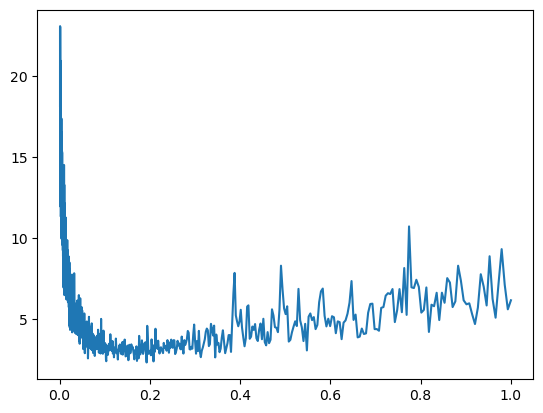

In [37]:
plt.plot(lri, lossi);

Let's go ahead and determine the learning rate from `lri` associated with the lowest loss:

In [38]:
# Get index of smallest loss in lossi
print(lri[lossi.index(min(lossi))])

tensor(0.1929)


With this graph, we have a well-founded confirmation that $0.1$ is within a good region of values to choose for the learning rate.<br>
Smaller values have the descent bottom out at a too shallow level, while larger values make the descent too jumpy.<br> 
Note that now, towards the end of the training we can meaningfully apply what is called learning rate decay to further improve convergence.

**Ok, let's train properly now:**

In [39]:
# Reset the parameters once again
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

for p in parameters:
    p.requires_grad = True

In [40]:
for i in range(70000):
    
    # mini-batch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward-Pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate decay to more closely approach the minimum
    lr = 0.1 if i < 50000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad
    
# print('Loss for current mini-batch:', loss.item())

In [41]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.305272340774536


**We achieved a lower loss than before.** *But is that good? How do we know?*<br>
The model itself is small, only $3481$ parameters.<br>
Larger models could bring better performance, or worse cases of overfitting.<br><br>**How could we detect that?**

### Split the dataset

**The larger the model, the bigger the risk of it memorizing the dataset verbatim.**<br>
This is called **overfitting**. We've seen this before.<br>
To avoid our performance measurements getting distorted by how well the model may have just memorized instead of generalized,<br>we need to split the dataset into distinct subsets for **training**, **validation** and **testing**.<br>The model will never be trained on the **validation** and **testing** subsets, ever.<br>Therefore, we can use these subsets to measure the generalization performance of the model from the training data to unseen data.<br>

There are the `training split`, the `dev/validation split` and the `test split`.<br> The distribution of the data among these subsets is roughly chosen domain-independently like this: $80\%$, $10\%$, $10\%$

**Splitting the datset looks like this:**

In [ ]:
import random

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, '\tY:', Y.shape)
    return X,Y

random.seed(42)          # for reproducibility
random.shuffle(words)    # words is just the bare list of all names, from wayyy above

n1 = int(0.8*len(words)) # index at 80% of all words (rounded for integer indexing)
n2 = int(0.9*len(words)) # index at 90% of all words (rounded for integer indexing)

print('Training Set:')
Xtr, Ytr = build_dataset(words[:n1])     # The first 80% of all words
print('Validation Set:')
Xdev, Ydev = build_dataset(words[n1:n2]) # The 10% from 80% to 90% of all words
print('Test Set:')
Xte, Yte = build_dataset(words[n2:])     # The 10% from 90% to 100% of all words

Training Set:
X: torch.Size([182625, 3]) 	Y: torch.Size([182625])
Validation Set:
X: torch.Size([22655, 3]) 	Y: torch.Size([22655])
Test Set:
X: torch.Size([22866, 3]) 	Y: torch.Size([22866])


Before we play around with the model architecture, let's first see how well the current model performs on the validation set and the test set when trained on the training set only:

In [43]:
# Reset the parameters once again
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

3481 parameters


Let's train:

In [ ]:
for i in range(40000):
    
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate decay to more closely approach the minimum
    lr = 0.1 if i < 30000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad
    
# print('Loss for current mini-batch:', loss.item())

The validation loss now can be calculated like so:

In [45]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.34187912940979


The test loss can be calculated in a very similar way:

In [46]:
# Test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.338966131210327


We can see that validation and test loss are about equal. **This is good.**<br>
It means that the model is not overfitting.<br>
The model is not overpowered enough to memorize the training set, as it's too small.<br><br>**We underfit.**<br><br>
This is a sign that we are in fact able to increase the model size without risking overfitting *too quickly*.<br>

---

**Why do we have two seperate splite for validation and testing?**<br>
During real training runs, the validation set is used to tune the model's hyperparameters, such as the learning rate, the number of layers, the number of neurons per layer, etc.<br>
If overdone, optimizations with regards to the validation set can lead to overfitting to the validation set itself.<br>
This is why we need another subset: The test set.<br>
The test set is only used at the very end to evaluate the final generalization capability and performance of the model after all the hyperparameter tuning concluded.

---

If we want to really see the impact of splitting the dataset, we need to start playing around with the total parameter count of the model.<br>
We can do this by changing the previously already arbitrarily set width of the hidden layer. 

Let's try a width of $300$ instead of $100$:

In [47]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn((300), generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

10281 parameters


In [48]:
lossi = [] # list of losses per mini-batch
stepi = [] # list of steps (mini-batches)

for i in range(180000):
    
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) 
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if i < 60000 else 0.05 if i < 120000 else 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
    
    # Loss per mini-batch tracking
    stepi.append(i)
    lossi.append(loss.item())
    
#print('Loss for current mini-batch:', loss.item())

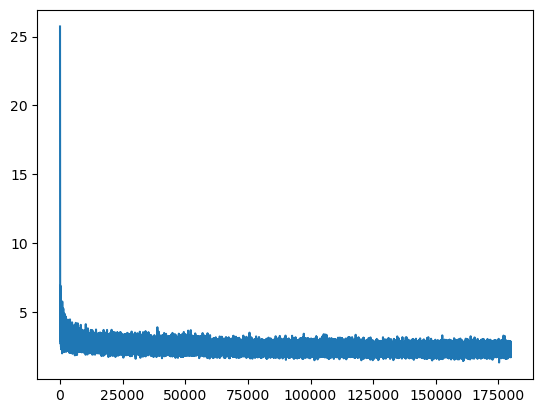

In [49]:
plt.plot(stepi, lossi);

The plot's hockeystick shape and thickness are caused by mini-batch gradient descent.<br>
More precisely, different mini-batches cause slightly deviating, different loss values, as the mini-batches are randomly drawn from the training set.<br>
In total, though, the loss visibly converges and follows the same general trend.

> **In general, the larger the batch size, the more stable the training process, the more memory is required.**

In [50]:
# Training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.2207682132720947


In [51]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.2277145385742188


In [52]:
# Test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.229692220687866


The losses for the training set, the validation set and the test set are in the same vicinity.<br>
**This is good.** It means that the model is (still) not overfitting.<br>

Let's now actually go and visualize the embeddings that were trained by the model (the weights and biases of the embedding layer).<br>
We visualize `C`, because that is where we put the trainable, two-dimensional embedding vectors.<br><br>
Let's see if the training affected these embeddings in a meaningful way:

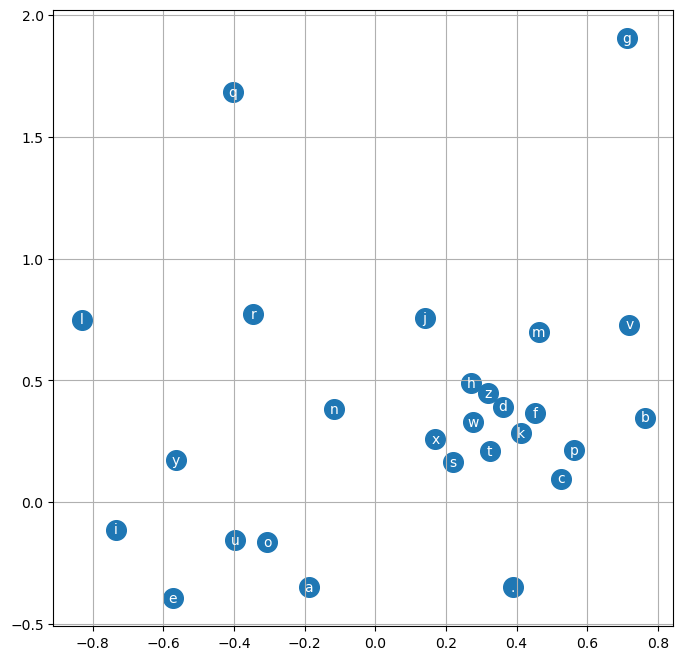

In [53]:
# This code plots the 2-dimensional embeddings of the 27 characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

We can see the vowels are clustered together.<br>
This means that the model has learned that vowels are, to some extend, interchangeable and therefore share somewhat similar characteristics.<br>
`q` seems to be very unique, just like our special `.` character. **We can see structure in the embedding space. The embeddings aren't just scattered in pure randomness.**<br>

Let's optimize further beyond increasing the model's hidden layer.<br>
Let's tackle the next possible bottleneck: **The dimensions of the character embeddings.**

## Remove the Embedding Bottleneck

For a first run, let's increase the embedding dimensions to $10$.<br>
With the below code, **the goal was to beat Andrej's validation loss of $2.17$:**

In [54]:
import tqdm
import random

In [55]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, '\tY:', Y.shape)
    return X,Y

random.seed(42)          # for reproducibility
random.shuffle(words)    # words is just the bare list of all names, from wayyy above
n1 = int(0.8*len(words)) # index at 80% of all words (rounded for integer indexing)
n2 = int(0.9*len(words)) # index at 90% of all words (rounded for integer indexing)

print('Training Set:')
Xtr, Ytr = build_dataset(words[:n1])     # The first 80% of all words
print('Validation Set:')
Xdev, Ydev = build_dataset(words[n1:n2]) # The 10% from 80% to 90% of all words
print('Test Set:')
Xte, Yte = build_dataset(words[n2:])     # The 10% from 90% to 100% of all words

Training Set:
X: torch.Size([182580, 3]) 	Y: torch.Size([182580])
Validation Set:
X: torch.Size([22767, 3]) 	Y: torch.Size([22767])
Test Set:
X: torch.Size([22799, 3]) 	Y: torch.Size([22799])


In [56]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True
    
lossi = []
stepi = []

11897 parameters


In [57]:
for i in tqdm.tqdm(range(300000)):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (128,)) # Batch size was 32 before, now 128
    
    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h1 = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 300)
    logits = h1 @ W2 + b2 # (32, 50)
    loss = F.cross_entropy(logits, Ytr[ix]) # (32,)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 60000 else 0.05 if i < 120000 else 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())
    
# print('Loss for current mini-batch:', loss.item())

100%|██████████| 300000/300000 [08:27<00:00, 591.58it/s]


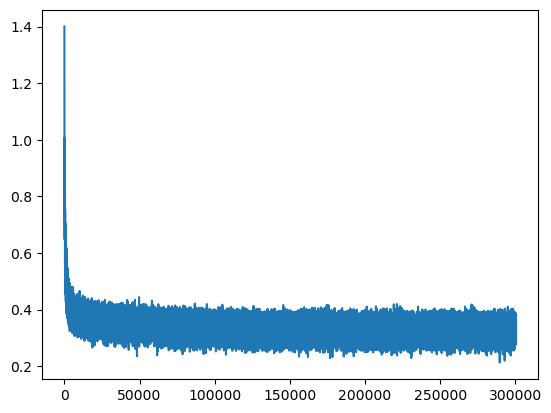

In [58]:
plt.plot(stepi, lossi);

In [59]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1522507667541504


In [60]:
# Training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.12158203125


Training and validation performance are slightly, very slowly, drifting apart. **This is a sign of overfitting.**<br>
We could for example now increase the model input from three to four characters per tuple.<br>
You can see how tuning a neural network requires considering multiple moving parts, each in turn impacting the others.

With our current optimizations, we can now go ahead and see how we perform with generating names:

In [61]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

mona.
mayah.
see.
mad.
ryla.
rethan.
endrlee.
adelynneliah.
milopaleigh.
van.
aarvelynn.
hone.
cayshaberg.
himiel.
kindreellerenteromi.
brence.
ryyah.
faeha.
kayshayton.
mahia.


<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>